# Testing

In [1]:
push!(LOAD_PATH, pwd()) # put current directory on path
using Revise
using UnPack
using LaTeXStrings
#include("ModelHelperFuns.jl")  # load the file
#using .ModelHelperFuns         # bring the module into scope
using CooperativeHuntingPkg
using Plots
default(
    guidefontsize=14,   # controls xlabel, ylabel, title font size
    tickfontsize=12,    # controls axis number labels
    legendfontsize=14,  # controls legend font
    linewidth=2,        # controls default line thickness
    grid = false        # turns off grid in background
)
using DifferentialEquations

In [164]:
# define parameters
parameters = Dict(
    :α1_of_1 => 0.05,
    :α2_of_1 => 0.95,
    :s1 => 2,
    :s2 => 2,
    :H1a => 1,
    :H1b => 0,
    :H2a => 0,
    :H2b => 0,
    :A1 => 0.6,
    :A2 => 0.5,
    :η1 => 0.6,
    :η2 => 0.2,
    :β1 => 5,
    :β2 => 1,
    :α2_fun_type => "sigmoid",
    :x_max => 2,
    :Tg => .01,
    :d => 100
)

Dict{Symbol, Any} with 18 entries:
  :A1          => 0.6
  :η1          => 0.6
  :α1_of_1     => 0.05
  :H2b         => 0
  :β2          => 1
  :β1          => 5
  :H1b         => 0
  :Tg          => 0.01
  :d           => 100
  :A2          => 0.5
  :s1          => 2
  :H1a         => 1
  :H2a         => 0
  :x_max       => 2
  :α2_of_1     => 0.95
  :η2          => 0.2
  :α2_fun_type => "sigmoid"
  :s2          => 2

# Group Dynamics

In [58]:
# set up inputs
@unpack x_max = parameters
du = fill(.01, 2+ x_max);
u = [0.9, 0.8, fill(0.1, x_max)...]
@unpack x_max, Tg, η1, η2 = parameters
p = parameters;

In [59]:
N1, N2 = u[1], u[2]
g = u[3:end]
xvec = 1:x_max
td = 1 - η1 - η2    #  tilde{\delta}
# i'll need fitnesses and best response functions
Wvec = fun_W(xvec, N1, N2, p)
W1 = Wvec[1]
S_1_x = fun_S_given_W(W1,Wvec[2:end], p) # [S(1,2), S(1,3),...,S(1,x_max)]
S_1_x = vcat(1/2, S_1_x) # this makes it easier to index
dg = du[3:end];

## $\partial g(1) / \partial t$

In [61]:
if x_max == 1
    groups_2_split = 0
    join_groups = 0
    leave_larger_grps = 0
    births = g[1]*Wvec[1]
    deaths = - td*g[1]
else
    groups_2_split = 4*g[2]*S_1_x[2]/Tg
    join_groups = -(g[1]/Tg)*sum(g[1:end-1].*(1 .- S_1_x[2:end]))
    births = x_max*g[x_max]*Wvec[x_max] - g[1]*Wvec[1]
    deaths = 2*td*g[2] - td*g[1]
    if x_max > 2
        leave_larger_grps = sum(xvec[3:end].*g[3:end].*S_1_x[3:end])/Tg
    else
        leave_larger_grps = 0
    end
end
births = deaths = 0 # for testing
dg[1] = groups_2_split + leave_larger_grps + join_groups + births + deaths


-0.3736228044234392

## $\partial g(2) / \partial T$

In [ ]:
# x = 2
individual_leaves = - 2*g[2]*S_1_x[2]/Tg
if x_max == 2
    threes_to_pairs = 0
    pairs_to_threes = 0
    deaths = -2*td*g[2]
    births = g[1]*Wvec[1]
else
    pairs_to_threes = - g[2]*g[1]*(1-S_1_x[3])/Tg
    threes_to_pairs = 3*g[3]*S_1_x[3]/Tg
    deaths = td * (3*g[3] - 2*g[2])
    births = g[1]*Wvec[1] - 2*g[2]*Wvec[2]
end
form_dyads = (g[1])^2*(1-S_1_x[2])/(2*Tg)
dg[2] = (individual_leaves + pairs_to_threes + form_dyads + threes_to_pairs
    + births + deaths)

0.18681140221171966

In [63]:
dg[1] + 2*dg[2]

1.1102230246251565e-16

In [140]:
# define parameters
p = Dict(
    :α1_of_1 => 0.05,
    :α2_of_1 => 0.95,
    :s1 => 2,
    :s2 => 2,
    :H1a => 0,
    :H1b => 0,
    :H2a => 1,
    :H2b => 1,
    :A1 => 0.6,
    :A2 => 0.5,
    :η1 => 0.6,
    :η2 => 0.2,
    :β1 => 5,
    :β2 => 1,
    :α2_fun_type => "sigmoid",
    :x_max => 5,
    :Tg => .01,
    :d => 100
)
p_named_tuple = NamedTuple(p)
# initial point
du = fill(0.01,p[:x_max]+2)
u = [0.8; 0.7; fill(0.1,p[:x_max])...]
tspan = (0.0, 300.0)
dg = fun_dg!(du, u, p_named_tuple, 1)


5-element Vector{Float64}:
 -3.9999999996861124
 -0.5000000001469482
  1.2671280057359194e-16
  1.999139627477513e-11
  0.9999999999800088

In [145]:
xvec = 1:x_max
sum(xvec.*dg)

0.0

# Test ODE system

In [4]:
# define parameters
params = Dict(
    :α1_of_1 => 0.05,
    :α2_of_1 => 0.95,
    :s1 => 2,
    :s2 => 2,
    :H1a => 0,
    :H1b => 0,
    :H2a => 1,
    :H2b => 1,
    :A1 => 0.6,
    :A2 => 0.5,
    :η1 => 0.6,
    :η2 => 0.2,
    :β1 => 5,
    :β2 => 1,
    :α2_fun_type => "sigmoid",
    :x_max => 5,
    :Tg => .01,
    :d => 100
)
p_nt = NamedTuple(params)
# initial point
du = fill(0.01,p_nt[:x_max]+2)
u0 = [0.8; 0.7; fill(0.1,p_nt[:x_max])...]
tspan = (0.0, 300.0)
prob = ODEProblem(fullsystem!, u0, tspan, p_nt)
sol = solve(prob)

retcode: Success
Interpolation: 3rd order Hermite
t: 334-element Vector{Float64}:
   0.0
   0.02658221970833896
   0.038877845544271636
   0.06422681020609183
   0.08567952863437178
   0.11379137423173405
   0.14344148571974333
   0.17945495231538366
   0.22095974179103228
   0.27181137712795894
   ⋮
 124.80513183425599
 138.11461268498775
 146.02881056388534
 165.02269304052453
 183.71072014942953
 207.42940197654494
 239.8290535889884
 292.5184141140812
 300.0
u: 334-element Vector{Vector{Float64}}:
 [0.8, 0.7, 0.1, 0.1, 0.1, 0.1, 0.1]
 [0.7983224220033907, 0.7005323778015055, 0.04375242257128758, 0.08797545125362984, 0.09636280695801626, 0.09997554354316131, 0.12101309452043839]
 [0.7975150434437388, 0.7008393147186481, 0.03277649926198206, 0.08427443164519545, 0.09458771701583299, 0.0999535915463573, 0.12706390561516218]
 [0.7958248274257586, 0.7015280680041179, 0.021356732053824747, 0.07861439852618742, 0.0911454588008447, 0.09992794331407573, 0.13637813070110202]
 [0.794381339628

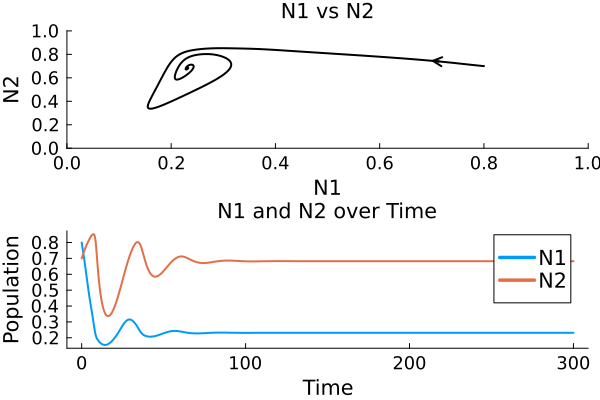

In [5]:
using Plots

# Extract N1 and N2 from the solution
N1 = sol[1, :]  # First component of the solution
N2 = sol[2, :]  # Second component of the solution
# Plot N1 vs N2
plot1 = plot(N1, N2, xlabel="N1", ylabel="N2", title="N1 vs N2", legend=false, 
        xlims = (0,1), ylims = (0,1), color = :black)

start_ind = 20
plot!(N1[start_ind:start_ind+1], N2[start_ind:start_ind+1], 
        arrow=true, linewidth=2,  legend=false, color = :black)

plot2 = plot(sol.t, [N1, N2], label=["N1" "N2"], 
    xlabel="Time", ylabel="Population", title="N1 and N2 over Time")
# Add an arrow to indicate direction
# Choose a point and the next point to determine the arrow's direction

plot(plot1, plot2, layout = (2,1))

In [163]:
println(latexstring("(N_1,N_2) = ($(N1[end]), $(N2[end]))"))

println(sol[3,:][end])

println(sol[4,:][end])
println(sol[5,:][end])
println(sol[6,:][end])
println(sol[7,:][end])

$(N_1,N_2) = (0.23145155668072806, 0.6824156188085729)$
0.19726663826834287
0.04389917211215002
0.6365691055633692
0.1707265815889342
0.0014545460488339997


# Test scaled system

In [62]:

params = Dict(
    :α1_of_1 => 0.05,
    :α2_of_1 => 0.95,
    :s1 => 2,
    :s2 => 2,
    :H1a => 0,
    :H2a => 0,
    :H2b => 0,
    :A1 => 0.6,
    :A2 => 0.5,
    :η2 => 0.6,
    :β2 => 1,
    :α2_fun_type => "constant",
    :x_max => 5,
    :Tg => .01,
    :d => 100,
    :scale => 5
)



Dict{Symbol, Any} with 16 entries:
  :A1          => 0.6
  :α1_of_1     => 0.05
  :β2          => 1
  :H2b         => 0
  :Tg          => 0.01
  :d           => 100
  :A2          => 0.5
  :s1          => 2
  :H1a         => 0
  :H2a         => 0
  :scale       => 5
  :x_max       => 5
  :α2_of_1     => 0.95
  :η2          => 0.6
  :α2_fun_type => "constant"
  :s2          => 2

In [63]:
u0 = [0.1,0.1, fill(0.1,params[:x_max])...]

p_nt = NamedTuple(scale_parameters(params))

(A1 = 0.6, α1_of_1 = 0.05, β2 = 1, H2b = 0, Tg = 0.01, d = 100, β1 = 5, η1 = 0.12, H1b = 0.0, A2 = 0.5, s1 = 2, H1a = 0, H2a = 0, scale = 5, x_max = 5, α2_of_1 = 0.95, η2 = 0.6, α2_fun_type = "constant", s2 = 2)

In [64]:
tspan = (0.0, 500)
prob = ODEProblem(fullsystem_scaled!, u0, tspan, p_nt)
sol = solve(prob)

retcode: Success
Interpolation: 3rd order Hermite
t: 289-element Vector{Float64}:
   0.0
   0.00608284362910561
   0.008844600740862517
   0.013816649194615883
   0.017900949102877713
   0.02318000293482867
   0.02854228623985088
   0.03496499955172433
   0.0420888065229754
   0.05048606802337448
   ⋮
 143.5767320579867
 157.86593082204251
 173.89421518615768
 191.9227587996389
 215.16036415415516
 246.6489132808866
 291.62026781210943
 362.72670040464993
 500.0
u: 289-element Vector{Vector{Float64}}:
 [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
 [0.09993697021121105, 0.10017287766857642, 0.16376263368368255, 0.09626842236433594, 0.12341166399804394, 0.14168885472120746, 0.040991239703927]
 [0.09990762325795234, 0.10024694050628592, 0.17438999405778619, 0.09528870569311804, 0.13470420995409607, 0.14529932488214495, 0.02943631860582007]
 [0.09985365464282797, 0.10037743247005655, 0.18047782927190215, 0.09421892471891469, 0.153614408213128, 0.14328676191092812, 0.01862920556775341]
 [0.099808281

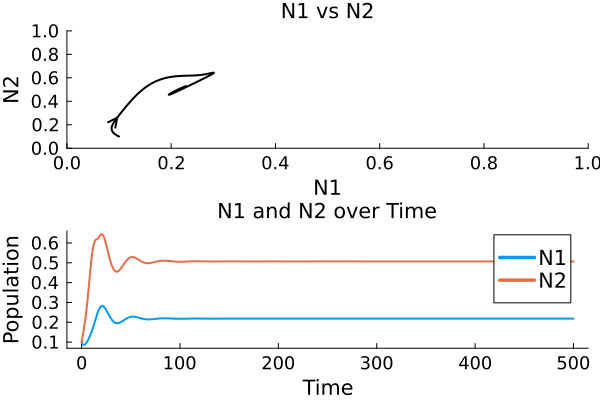

In [65]:
using Plots

# Extract N1 and N2 from the solution
N1 = sol[1, :]  # First component of the solution
N2 = sol[2, :]  # Second component of the solution
# Plot N1 vs N2
plot1 = plot(N1, N2, xlabel="N1", ylabel="N2", title="N1 vs N2", legend=false, 
        xlims = (0,1), ylims = (0,1), color = :black)

start_ind = 100
plot!(N1[start_ind:start_ind+1], N2[start_ind:start_ind+1], 
        arrow=true, linewidth=2,  legend=false, color = :black)

plot2 = plot(sol.t, [N1, N2], label=["N1" "N2"], 
    xlabel="Time", ylabel="Population", title="N1 and N2 over Time")
# Add an arrow to indicate direction
# Choose a point and the next point to determine the arrow's direction

plot(plot1, plot2, layout = (2,1))

## Get p, mean x

In [11]:
@unpack x_max = params
x = 1:x_max
g = sol[3:end,:]

5×289 Matrix{Float64}:
 0.1  0.163763   0.17439    0.180478   0.179206   …  0.419635     0.419636
 0.1  0.0962684  0.0952887  0.0942189  0.0936863     0.128555     0.128555
 0.1  0.123412   0.134704   0.153614   0.167318      0.0745843    0.0745838
 0.1  0.141689   0.145299   0.143287   0.138608      0.000214216  0.000214214
 0.1  0.0409912  0.0294363  0.0186292  0.0143885     3.83413e-7   3.8341e-7

In [12]:
x.*g

5×289 Matrix{Float64}:
 0.1  0.163763  0.17439   0.180478  0.179206   …  0.419635     0.419636
 0.2  0.192537  0.190577  0.188438  0.187373      0.25711      0.257109
 0.3  0.370235  0.404113  0.460843  0.501953      0.223753     0.223751
 0.4  0.566755  0.581197  0.573147  0.55443       0.000856862  0.000856857
 0.5  0.204956  0.147182  0.093146  0.0719424     1.91707e-6   1.91705e-6

In [13]:
pvec = sum(x.*g,dims=1)

1×289 Matrix{Float64}:
 1.5  1.49825  1.49746  1.49605  1.4949  …  0.901365  0.901356  0.901356

In [41]:
p = pvec

x_vec = 1:x_max
numerator = (x_vec.^2) .* g
mask = (p .> 1e-10) .& all(g .> 0, dims=1)
numerator_sum = sum(numerator, dims=1)
ans = copy(p)
ans[mask] .= numerator_sum[mask] ./ p[mask]
ans[.!mask] .= 1
return ans
# end

1×289 Matrix{Float64}:
 3.66667  3.30476  3.22452  3.1404  …  1.78457  1.78459  1.78459  1.78459

In [48]:
p

1×289 Matrix{Float64}:
 1.5  1.49825  1.49746  1.49605  1.4949  …  0.901365  0.901356  0.901356

In [60]:
gf = g[:,end]
pf = p[end]
numerator = x_vec.^2 .* gf
if pf < 1e-10 && all(gf .> 0)
    println(1)
else
    println(sum(numerator)/pf)
end

1.784585344763859


In [61]:
get_meanx(g[:,end],x_max,p[end])



1.784585344763859

In [46]:
methods(get_meanx)

# 1 method for generic function "get_meanx" from CooperativeHuntingPkg.AnalyzeResults:
 [1] get_meanx(g::AbstractMatrix, x_max::Int64, p::AbstractVector)
     @ ~/Documents/CH_GroupFormation/CH_code/Julia_version/CooperativeHuntingPkg/src/AnalyzeResults.jl:16

In [35]:
x_vec = 1:x_max
numerator = (x_vec.^2) .* g
pvec .> 1e-10 .&& pvec .>1e-10

1×289 BitMatrix:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  1  1  1  1  1  1  1  1  1  1  1  1

# Plot Best Response

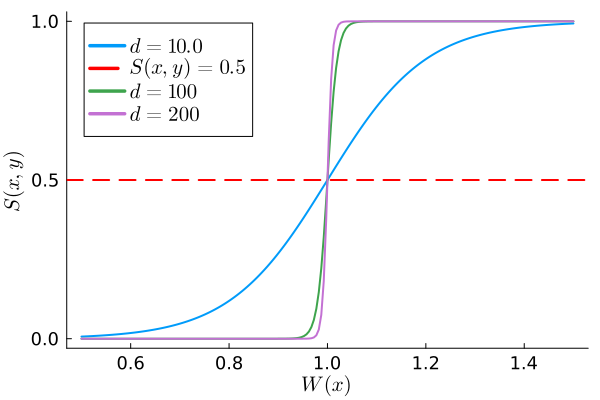

In [4]:

# Define Wx as a vector from 0 to 2
Wx = range(0.5, 1.5, length=200)

# Set Wy to 1
Wy = 1

# Evaluate S
parameters[:d] = 10.0
S = fun_S_given_W(Wx, Wy, parameters)

attributes = (xlabel=L"$W(x)$", ylabel=L"$S(x,y)$", yticks = [0, 0.5, 1])
# Plot
label=latexstring("d = $(parameters[:d])")
plot(Wx, S, label = label;attributes...)
hline!([0.5], linestyle=:dash, color=:red, label=L"S(x,y) = 0.5")
#beautify_plot!(L"$W_x$",L"$S(x,y)$")


parameters[:d] = 100
plot!(Wx,fun_S_given_W(Wx, Wy, parameters),label=latexstring("d = $(parameters[:d])"))

parameters[:d] = 200
plot!(Wx,fun_S_given_W(Wx, Wy, parameters),label=latexstring("d = $(parameters[:d])"))

parameters[:d]

In [105]:
fun_H1(5,params)

0.1

In [41]:
dic2 = (a=1,b=2)

(a = 1, b = 2)

In [27]:
@unpack a,b = dic2

Dict{Symbol, Int64} with 2 entries:
  :a => 1
  :b => 2

In [43]:
dic2.a

1

LoadError: MethodError: no method matching setindex!(::@NamedTuple{a::Int64, b::Int64}, ::Int64, ::Symbol)
The function `setindex!` exists, but no method is defined for this combination of argument types.

In [55]:
u=[1,2,3]

3-element Vector{Int64}:
 1
 2
 3

In [53]:
u[1]

1

In [54]:
u[2]

2

# Going through bifurcationkit tutorial

https://bifurcationkit.github.io/BifurcationKitDocs.jl/dev/gettingstarted/

Example:
$$
\mu + x - \frac{x^3}{3} = 0
$$
for parameter $\mu$, $x \in \mathbb{R}$

We'll start with
$ (x_0, \mu_0) \approx (-2,-1)$

In [62]:
using Pkg
Pkg.add("BifurcationKit")
Pkg.add("LaTeXStrings")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [63]:
using BifurcationKit, LaTeXStrings

## Step 1: Define problem

In [64]:
F(x,p) = @.p[1] + x - x^3/3
prob = BifurcationProblem(F, 
    [-2.], #x0
    [-1.], #parameters
    1; #parameter index for continuation
    record_from_solution = (x,p; k...) -> x[1] # control what is recorded from each step
)

┌─ Bifurcation Problem with uType Vector{Float64}
├─ Inplace:  false
├─ Dimension:  1
├─ Symmetric: false
└─ Parameter: p1

## Step 2: Solve problem

In [65]:
br = continuation(prob, PALC(),ContinuationPar(p_min = -1., p_max = 1.))

 ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 54
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter p1 starts at -1.0, ends at 1.0
 ├─ Algo: PALC
 └─ Special points:

- #  1,       bp at p1 ≈ +0.66666320 ∈ (+0.66666320, +0.66666655), |δp|=3e-06, [converged], δ = ( 1,  0), step =  20
- #  2,       bp at p1 ≈ -0.66666618 ∈ (-0.66666650, -0.66666618), |δp|=3e-07, [converged], δ = (-1,  0), step =  38
- #  3, endpoint at p1 ≈ +1.00000000,                                                                     step =  53


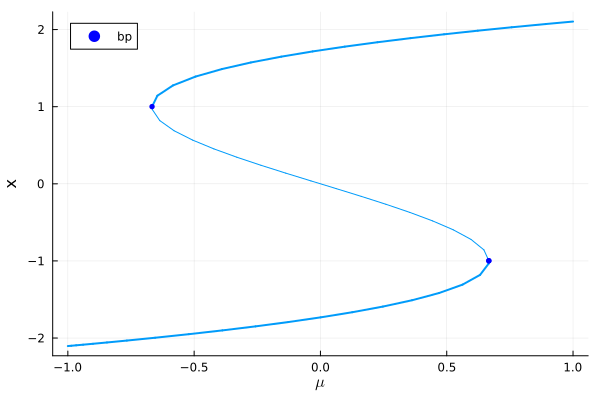

In [69]:
using Plots
scene = plot(br, plotstability = true, xlabel = L"\mu")

### plotting without plot recipe

from https://bifurcationkit.github.io/BifurcationKitDocs.jl/dev/plotting/

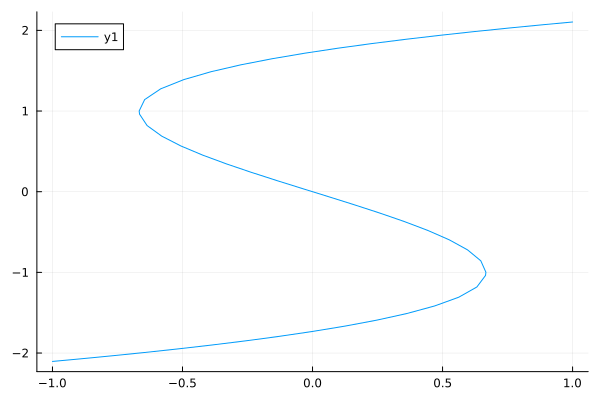

In [70]:
plot(br.branch.param, br.branch.x)

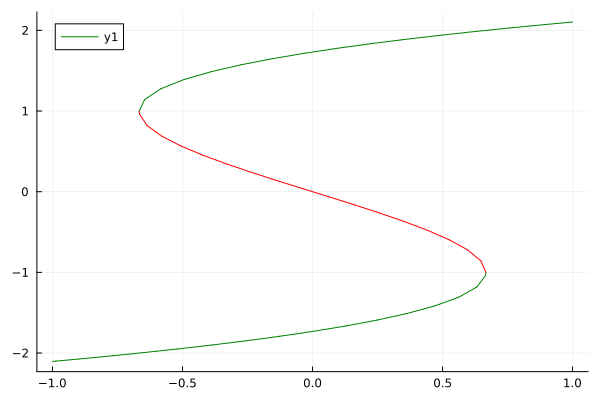

In [71]:
col = [stb ? :green : :red for stb in br.stable]
plot(br.param, br.x, color=col)


## Step 3: Analyze solution

In [8]:
show(br)

 ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 54
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter p1 starts at -1.0, ends at 1.0
 ├─ Algo: PALC
 └─ Special points:

- #  1,       bp at p1 ≈ +0.66666320 ∈ (+0.66666320, +0.66666655), |δp|=3e-06, [converged], δ = ( 1,  0), step =  20
- #  2,       bp at p1 ≈ -0.66666618 ∈ (-0.66666650, -0.66666618), |δp|=3e-07, [converged], δ = (-1,  0), step =  38
- #  3, endpoint at p1 ≈ +1.00000000,                                                                     step =  53


In [14]:
br[5]

(x = -2.0742612536082805, param = -0.9006164054145794, itnewton = 2, itlinear = 2, ds = 0.04102643120243098, n_unstable = 0, n_imag = 0, stable = true, step = 4, eigenvals = ComplexF64[-3.3025597482205953 + 0.0im], eigenvecs = ComplexF64[1.0 + 0.0im;;])

In [15]:
propertynames(br)

(:branch, :eig, :sol, :contparams, :kind, :prob, :specialpoint, :alg)

# Another continuation example with some branching

Solve 
$$
0 = x \cdot (\mu - x)
$$
"In case we know there are many branches, the best is to use an automatic method to compute them all. We will focus on bifurcationdiagram which computes the connected component of the initial guess in the plane 
(
x
,
μ
)
(x,μ). An alternative is to use Deflated Continuation."

In [39]:
using Plots
using BifurcationKit

Fbp(u,p) = @. u*(p[1]-u) #@. does the broadcasting



Fbp (generic function with 1 method)

In [40]:
# bifurcation problem
prob = BifurcationProblem(Fbp, [0.0], [-0.2],
    # specify continutation parameter index
    1,
    record_from_solution= (x,p; k...) -> x[1])

┌─ Bifurcation Problem with uType Vector{Float64}
├─ Inplace:  false
├─ Dimension:  1
├─ Symmetric: false
└─ Parameter: p1

call bifurcationdiagram to recursively compute branches. here we need 2 recursions because of 2 branches

In [41]:
# options for continuation
opts_br = ContinuationPar(
    # parameter interval
    p_max = 0.2, p_min = -0.2,
    # detect bifurcations with bisection method
    # we increase the precision of the bisection
    n_inversion = 4)

# automatic bifurcation diagram computation
diagram = bifurcationdiagram(prob, PALC(),
    # the following parameter specifes the maximum amount of recursion 
    # for computing branches
    2,
    opts_br,
    )

[Bifurcation diagram]
 ┌─ From 0-th bifurcation point.
 ├─ Children number: 2
 └─ Root (recursion level 1)
      ┌─ Curve type: EquilibriumCont
      ├─ Number of points: 9
      ├─ Type of vectors: Vector{Float64}
      ├─ Parameter p1 starts at -0.2, ends at 0.2
      ├─ Algo: PALC
      └─ Special points:

- #  1,       bp at p1 ≈ +0.00108349 ∈ (-0.00333593, +0.00108349), |δp|=4e-03, [converged], δ = ( 1,  0), step =   6
- #  2, endpoint at p1 ≈ +0.20000000,                                                                     step =   8


In [51]:
plot(diagram.branches[1])

LoadError: type BifDiagNode has no field branches

## Example 3: continuing periodic orbits:

Stuart-Laundau oscillator:
$$
\frac{du}{dt} = ru - \nu v - (u^2 + v^2)(c_3u - \mu v) 
$$
$$
\frac{dv}{dt} = rv + \nu v - (u^2 + v^2)(c_3 + \mu u)
$$

In [14]:
a

1

In [15]:
using BifurcationKit, Plots

function Fsl(X,p)
    (;r, μ, ν, c3) = p
    u, v = X
    ua = u^2 + v^2
    [
        r * u - ν * v - ua * (c3 * u - μ * v)
        r * v + ν * u - ua * (c3 * v + μ * u)
    ]
end

Fsl (generic function with 1 method)

In [21]:
par_sl = (r=0.1, μ = 0., ν = 1.0, c3 = 1.0)
u0 = zeros(2) # start continuation at (0,0)
prob = BifurcationProblem(Fsl, u0, par_sl, 
    #  I think the following chooses r as the bifurcation parameter
    (@optic _.r))

# we want to locate a Hopf Bifurcation
br = continuation(prob, PALC(), ContinuationPar(), 
    # bothside = true means "compute the branches on the 
    # 2 sides of the initial parameter value p0, merge them and return it." (from ?continuation)
    bothside = true)

 ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 25
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter r starts at -1.0, ends at 1.0
 ├─ Algo: PALC
 └─ Special points:

- #  1, endpoint at r ≈ -1.00000000,                                                                     step =   0
- #  2,     hopf at r ≈ -0.00595553 ∈ (-0.00595553, +0.00299379), |δp|=9e-03, [converged], δ = ( 2,  2), step =   8
- #  3, endpoint at r ≈ +1.00000000,                                                                     step =  24


A hopf is detected! So we want the branch of periodic orbits nearby

To do this, we have to provide to continuation: 
* the branch br
* the special point to branch from (2 here)
* a method: PeriodicOrbitOCollProblem(20, 5) (WHAT DO THE NUMBERS MEAN?)
the number 20 is Ntst, and 5 is m... from looking athte documentation. i think these are for determining the size of two meshes in the collocation method

In [23]:
br_po = continuation(br, 2, ContinuationPar(),
    PeriodicOrbitOCollProblem(20,5)
    )

┌ Warning: We did not find the left eigenvalue for the Hopf point to be very close to the imaginary part:
│ λ  ≈ -0.00595553174342172 + 1.0im,
│ λ★ ≈ -0.00595553174342172 - 1.0im
│ You can perhaps increase the number of computed eigenvalues, the current number is nev = 2
└ @ BifurcationKit ~/.julia/packages/BifurcationKit/Eq8JI/src/NormalForms.jl:948


 ┌─ Curve type: PeriodicOrbitCont from Hopf bifurcation point.
 ├─ Number of points: 15
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter r starts at 0.00404446825657828, ends at 1.0
 ├─ Algo: PALC
 └─ Special points:

- #  1, endpoint at r ≈ +1.00000000,                                                                     step =  14


In [24]:
br_po[1]

(max = 0.06359613398726559, min = -0.06359613398726559, amplitude = 0.12719226797453118, period = 6.283185307179592, param = 0.00404446825657828, itnewton = 0, itlinear = 0, ds = 0.01, n_unstable = 0, n_imag = 0, stable = true, step = 0, eigenvals = ComplexF64[-9.729994587862209e-12 + 0.0im, -0.05082428707935851 + 0.0im], eigenvecs = nothing)

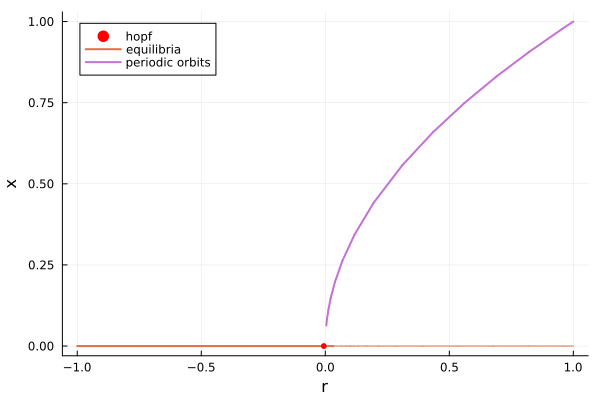

In [26]:
plot(br, br_po, branchlabel = ["equilibria", "periodic orbits"])

**is the purple line the upper limitof the periodic orbits? or the amplitude?**

In [28]:
br_po

 ┌─ Curve type: PeriodicOrbitCont from Hopf bifurcation point.
 ├─ Number of points: 15
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter r starts at 0.00404446825657828, ends at 1.0
 ├─ Algo: PALC
 └─ Special points:

- #  1, endpoint at r ≈ +1.00000000,                                                                     step =  14


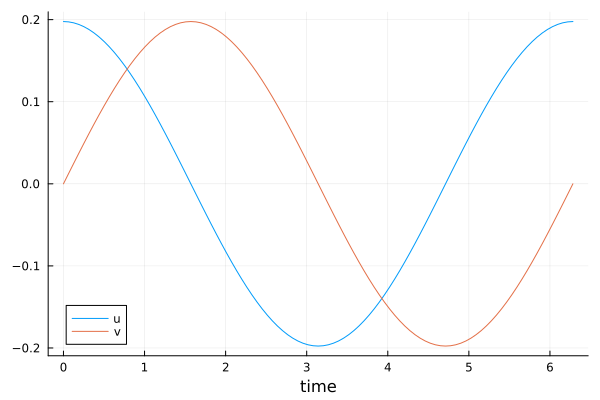

In [33]:
sol0 = get_periodic_orbit(br_po,5)
plot(sol0.t, sol0[1,:], label = "u", xlabel = "time")
plot!(sol0.t, sol0[2,:], label = "v", xlabel = "time")

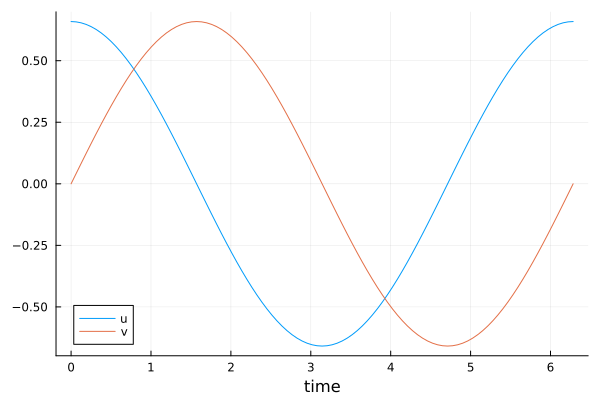

In [34]:
sol = get_periodic_orbit(br_po,10)
plot(sol.t, sol[1,:], label = "u", xlabel = "time")
plot!(sol.t, sol[2,:], label = "v", xlabel = "time")

In [27]:
?get_periodic_orbit

search: get_periodic_orbit getpredictor getperiod



```julia
get_periodic_orbit(prob, u, p)

```

Compute the full periodic orbit associated to `x`. Mainly for plotting purposes.

---

```julia
get_periodic_orbit(prob, u, p)

```

Compute the full periodic orbit associated to `x`. Mainly for plotting purposes.

---

```julia
get_periodic_orbit(prob, x, par; kode...)

```

Compute the full periodic orbit associated to `x`. Mainly for plotting purposes.

---

```julia
get_periodic_orbit(prob, x_bar, p)

```

Compute the full periodic orbit associated to `x`. Mainly for plotting purposes.
